In [6]:
import numpy as np
import pandas as pd

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [9]:
df=pd.read_csv("/content/APPLE STOCK PREDICTION.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


In [10]:
df.shape

(1664, 6)

In [11]:
df1=df.reset_index()['Close'];df1

0       157.48
1       155.32
2       161.06
3       160.08
4       158.81
         ...  
1659     48.02
1660     47.68
1661     47.71
1662     47.33
1663     47.08
Name: Close, Length: 1664, dtype: float64

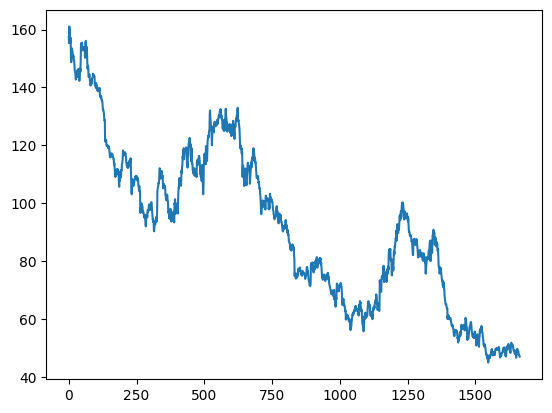

In [12]:
plt.plot(df1);plt.show()

In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1));df1

array([[0.96914059],
       [0.95052151],
       [1.        ],
       ...,
       [0.02292906],
       [0.01965348],
       [0.01749849]])

In [14]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size,test_size)

1081 583


In [15]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape),print(X_test.shape), print(ytest.shape)

(980, 100)
(980,)
(482, 100)
(482,)


(None, None, None, None)

In [18]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

In [23]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 39ms/step


In [24]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(ytest,test_predict)))

100.98150997776841
68.48293770303124


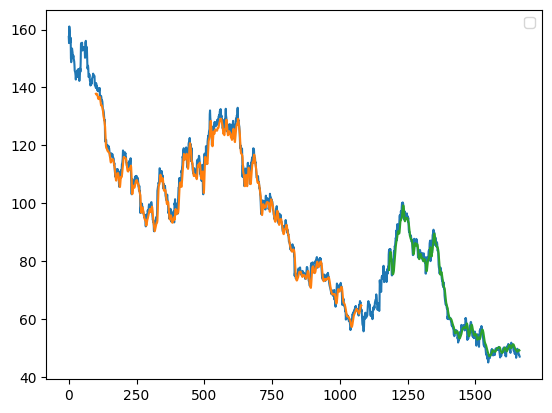

In [26]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [27]:
x_input=test_data[483:].reshape(1,-1) #len(test_data)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [28]:
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.03225296]
101
1 day input [0.02077407 0.02344625 0.02448065 0.03103181 0.03016981 0.02560124
 0.02206706 0.03094561 0.03844496 0.03922076 0.04197914 0.03973795
 0.03853116 0.03870356 0.04215154 0.04042755 0.03810016 0.04284113
 0.03870356 0.04284113 0.04318593 0.04637531 0.04353073 0.03335919
 0.02775623 0.02034307 0.01491251 0.02103267 0.02560124 0.02103267
 0.01905008 0.02430825 0.02801483 0.02792863 0.02896302 0.0318076
 0.03594518 0.04085855 0.04094475 0.04387553 0.04318593 0.04456512
 0.03646237 0.02939402 0.0318076  0.02948022 0.01887768 0.02379105
 0.01801569 0.03706577 0.04706491 0.04508232 0.03853116 0.04568572
 0.04973709 0.04930609 0.05499526 0.05447806 0.04525472 0.04180674
 0.04663391 0.04042755 0.03387639 0.03361779 0.02861822 0.04335833
 0.05292647 0.05887423 0.05482286 0.05396087 0.05111628 0.0482717
 0.05275407 0.0490475  0.04499612 0.03835876 0.03456599 0.03568658
 0.03654857 0.02948022 0.02551504 0.03430739 0.03508318 0.0320662
 0.02723903 0.01396431 0.02137747 0.

In [29]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

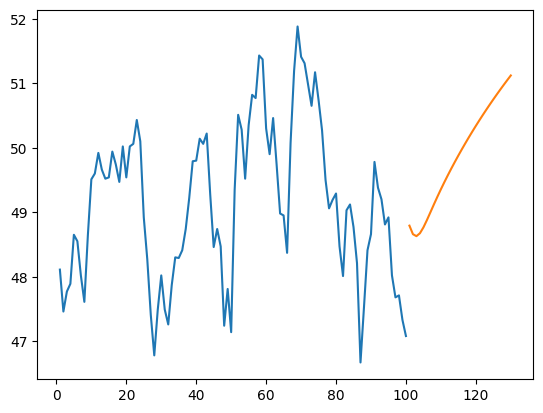

In [30]:
plt.plot(day_new,scaler.inverse_transform(df1[1564:])) #len(df1)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

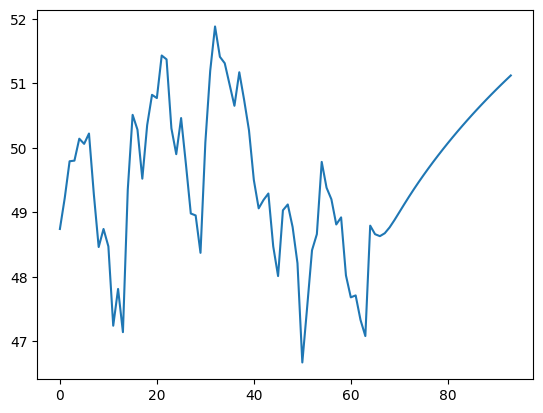

In [32]:

df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[1600:])

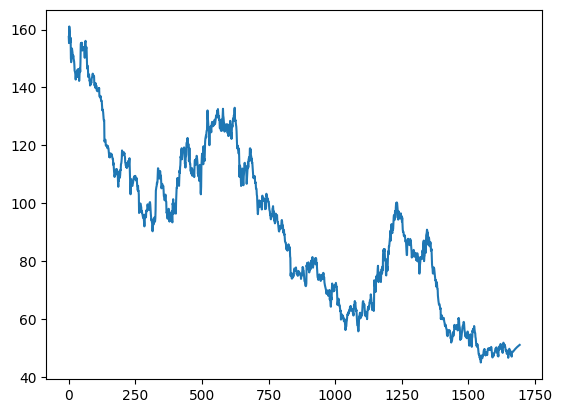

In [33]:
plt.plot(df3)